# FOWS Demo

This demo notebook exemplifies the experiments performed in the paper 'Spotting tell-tale visual artifacts in face swapping  videos: strengths and pitfalls of CNN detectors' (TODO: add link to paper).

It is possible to select a sample video clip depicting either the hand-based or object-based occlusion challenge, which gets preprocessed so as to extract the subject faces from video frames. Successively, it is specified in which frames the face is occluded (occ) and in which ones it is not (no-occ).

The notebook then allows to select the baseline model to be tested, as described in the paper. You just need to select the video and what kind of frames, either occluded (occ) or non-occluded (no_occ) you want to analyze. As a final step, the model's prediction are plotted to show the classification of real and swapped faces.

**Important:** in order to run this notebook make sure to connect to a GPU during runtime.

<!-- ## Instruction for use

SCRITTO COSI' QUI SEMBRA CHE QUESTE COSE LE DEBBANO FARE PRIMA DI GIRARE IL NOTEBOOK.. LE TOGLIEREI

INVECE VA DETTO DI SETTARE IL TIPO DI RUNTIME SU GPU (a meno che non lo faccia di default)




1. Clone the repository (or upload the repository on gDrive if you have already cloned it).
  
  Please note that cloning the repository in Colab will save it inside Colab's temporary memory. Meaning that, once the session is disconnected, every modification you did to the code will be deleted. In case you want to preserve your modification, please uploade to drive the cloned repo and connect colab to your Drive.
2. Upload the pretrained models in the model_weights folder
3. Install the requirements. Please note that you may need to restart the session to correctly install the packages.
4. Start by apply the proprocessing to the videos. You can raun this just once since both videos will be preprocessed.
5. Then, select either the occluded (occ) or non_occluded (no_occ) portion of the video to be analyzed with the pretrained model
6. Load the model and compute the predictions on the selected portion of the model
7. In general, try to pay attention to the comments and instruction reported in each section -->

## Install Requirements

In [ ]:
# test frames and face extraction with mediapipe face detector
!pip install mediapipe==0.10.20

# install mediapy to show video in colab demo
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

# install gdown to download baseline weights from gDrive
!pip install gdown
print("done")

done


If not done automatically by Colab, please restart the session! [Runtime -> Restart Session (or Ctrl + M)]

This ensures all packages have been correctly installed, especially mediapipe.

Once you have restarted the session, please run again the following cell to make sure the correct version of mediapipe has been installed (0.10.20)

In [ ]:
# run this cell to make sure the correct version has been installed
import mediapipe as mp
print(mp.__version__) # should be 0.10.20

0.10.20


## Clone the Repository


In [ ]:
# clone the repository
!git clone https://github.com/RickyZi/FOWS_test.git

Cloning into 'FOWS_test'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 281 (delta 110), reused 71 (delta 31), pack-reused 85 (from 1)
Receiving objects: 100% (281/281), 69.59 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [ ]:
# access the repository
%cd /content/FOWS_test/

/content/FOWS_test


Alternatively, you can clone the repo on your GDrive, download the models there and mount GDrive as follows:

In [ ]:
# connect notebook to you google Drive (if you want to save the results to the cloned repo uploaded to your gDrive)
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/FOWS_test/ # access the repo (update the path with your path to the cloned repo)

## Select Video Data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import os
import sys
import timm
import yaml
import glob
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import mediapy as media
from PIL import Image

In [ ]:
from notebook_demo.demo_utils import *
from preprocessing.frame_and_faces_extraction import *

In [ ]:
import sys
import os

# add the repo to the sys.path
# Important to have reference for loading FocalLoss definition
repo_path = '/content/FOWS_test/' # update the repo_path with your path to the repo

if repo_path not in sys.path:
    sys.path.append(repo_path)

In [ ]:
#@title Select and Display Sample Clips

#@markdown Select the challenge of interest, either hand-based or object-based occlusion. A real and a swapped sample video clips will be loaded.

#@markdown [Re-run the cell to change the selection]


# select video to show
vid = 'hand_occlusion' #@param ["hand_occlusion", "obj_occlusion"]
if vid == 'hand_occlusion':
  VIDEO_REAL = './notebook_demo/demo_videos/real/hand_occ_real.avi'
  VIDEO_FAKE = './notebook_demo/demo_videos/fake/hand_occ_fake.avi'
else:
  VIDEO_REAL = './notebook_demo/demo_videos/real/obj_occ_real.avi'
  VIDEO_FAKE = './notebook_demo/demo_videos/fake/obj_occ_fake.avi'
  # '/content/drive/MyDrive/Colab Notebooks/FOWS_demo/demo_videos/fake/obj_occ_fake.avi'




Note: both videos take 30/40 seconds to be displayed

In [ ]:
print(f"{vid} REAL VIDEO")
# Read, resize, and display a video:
video_real = media.read_video(VIDEO_REAL)
# print(f'Shape is (num_images, height, width, num_channels) = {video2.shape}.') # 396, 1080, 1920, 3
# if metadata := video2.metadata:
#   print(f'Framerate is {metadata.fps} frames/s.') # 30 fps
video3 = media.resize_video(video_real, tuple(np.array(video_real.shape[1:3]) // 3)) # 1/4 28 sec
media.show_video(video3)

hand_occlusion REAL VIDEO


In [ ]:
print(f"{vid} FAKE VIDEO")
# Read, resize, and display a video:
video_fake = media.read_video(VIDEO_FAKE)
# print(f'Shape is (num_images, height, width, num_channels) = {video2.shape}.') # 396, 1080, 1920, 3
# if metadata := video2.metadata:
#   print(f'Framerate is {metadata.fps} frames/s.') # 30 fps
video3 = media.resize_video(video_fake, tuple(np.array(video_fake.shape[1:3]) // 3)) # 1/4 28 sec
media.show_video(video3) #, codec='gif')

hand_occlusion FAKE VIDEO


## Preprocess Video Data
This cell performs the faces extraction from each video frame.
A folder is created for the selected challenge and the extracted faces are place there.

This step will be performed for both real and fake videos. Please run this and also the next cell to process all videos.

In [ ]:
print("\nREAL_VIDEOS")
real_vid = './notebook_demo/demo_videos/real/'
real_faces = './notebook_demo/user_faces/real/'
if not os.path.exists(real_faces):
  print("creating subfolders...")
  create_subfolders_demo(real_faces)
else:
  print("subfolders already exist")
  extract_subfolders(real_faces)

print("start extracting faces from videos...")
# should be placed in alphabetical order -> thus be the same
extract_faces_from_videos(sorted(extract_files(real_vid)), sorted(extract_subfolders(real_faces)))

sanity_check_faces_extraction(real_faces)  # sanity check to verify that the number of frames extracted from the videos is correct (390 frames)


REAL_VIDEOS
creating subfolders...
start extracting faces from videos...
extracting faces from video: ./notebook_demo/demo_videos/real/hand_occ_real.avi
saving faces to: ./notebook_demo/user_faces/real/hand_occlusion
done
extracting faces from video: ./notebook_demo/demo_videos/real/obj_occ_real.avi
saving faces to: ./notebook_demo/user_faces/real/obj_occlusion
done

sanity check: 
sub: ./notebook_demo/user_faces/real/hand_occlusion
number of frames extracted from the real videos is correct (= 390)
sub: ./notebook_demo/user_faces/real/obj_occlusion
number of frames extracted from the real videos is correct (= 390)


In [ ]:
print("\nFAKE_VIDEOS")

fake_vid = './notebook_demo/demo_videos/fake/'
fake_faces = './notebook_demo/user_faces/fake/'
if not os.path.exists(fake_faces):
  print("creating subfolders...")
  create_subfolders_demo(fake_faces)
else:
  print("subfolders already exist")
  extract_subfolders(fake_faces)

print("start extracting faces from videos...")

extract_faces_from_videos(sorted(extract_files(fake_vid)), sorted(extract_subfolders(fake_faces)))

sanity_check_faces_extraction(fake_faces) # sanity check to verify that the number of frames extracted from the videos is correct (390 frames)


FAKE_VIDEOS
creating subfolders...
start extracting faces from videos...
extracting faces from video: ./notebook_demo/demo_videos/fake/hand_occ_fake.avi
saving faces to: ./notebook_demo/user_faces/fake/hand_occlusion
done
extracting faces from video: ./notebook_demo/demo_videos/fake/obj_occ_fake.avi
saving faces to: ./notebook_demo/user_faces/fake/obj_occlusion
done

sanity check: 
sub: ./notebook_demo/user_faces/fake/hand_occlusion
number of frames extracted from the real videos is correct (= 390)
sub: ./notebook_demo/user_faces/fake/obj_occlusion
number of frames extracted from the real videos is correct (= 390)


## Categorize Occluded and Non-Occluded Frames

This block identifies frames presenting face occlusions or not.

**NOTE**: in the paper, this step was performed automatically with the preprocessing/fows_dataset_preprocessing.py script, and then was fine-tuned manually to ensure all images were correctly classified as occluded (occ) or non occluded (no_occ).

Here, the result of this frame categorization is hardcoded.

In [ ]:
dataset_path = './notebook_demo/user_faces/' #'user_faces/'
preprocessed_path = './notebook_demo/preprocessed_faces/' #'preprocessed_faces/'
organize_frames(dataset_path, preprocessed_path)
print("done organizing frames!")
print("sanity check on the organized frames (each folder should contain 100 frames)")
check_num_frames(preprocessed_path)

done organizing frames!
sanity check on the organized frames (each folder should contain 100 frames)
Directory ./notebook_demo/preprocessed_faces/real/hand_occlusion/no_occ contains exactly 100 frames.
Directory ./notebook_demo/preprocessed_faces/real/hand_occlusion/occ contains exactly 100 frames.
Directory ./notebook_demo/preprocessed_faces/real/obj_occlusion/no_occ contains exactly 100 frames.
Directory ./notebook_demo/preprocessed_faces/real/obj_occlusion/occ contains exactly 100 frames.
Directory ./notebook_demo/preprocessed_faces/fake/hand_occlusion/no_occ contains exactly 100 frames.
Directory ./notebook_demo/preprocessed_faces/fake/hand_occlusion/occ contains exactly 100 frames.
Directory ./notebook_demo/preprocessed_faces/fake/obj_occlusion/no_occ contains exactly 100 frames.
Directory ./notebook_demo/preprocessed_faces/fake/obj_occlusion/occ contains exactly 100 frames.


## Custom frame organization

In this demo the occluded and non-occluded frames organization is hardcoded.
In case you wanted to analyze a different subset of frames on your own videos you will have to modify the _occ_frames_ and _no_occ_frames_ dictionaries in the './notebook_demo/demo_utils.py' file. These dictionaries contain, respectively, the indices of the occluded and non-occluded frames in the video (the indices refer to the name of the frames in the subset of the video). By changing the indices in these dictionaries you can modify the frames on which the analysis will be performed.

Please note that these indices refers to the faces extracted from the video frames. As such, you first need to preprocess your videos by performing the face extraction step, and then the classify occluded and non-occluded frames by running the './preprocessing/fows_dataset_processing.py' script. As previously discussed, a manual revision of the results might be needed.
Lastly, you can select a particular subset of your video by updating the indicies of the occ_frames_ and no_occ_frames_ dictionaries.


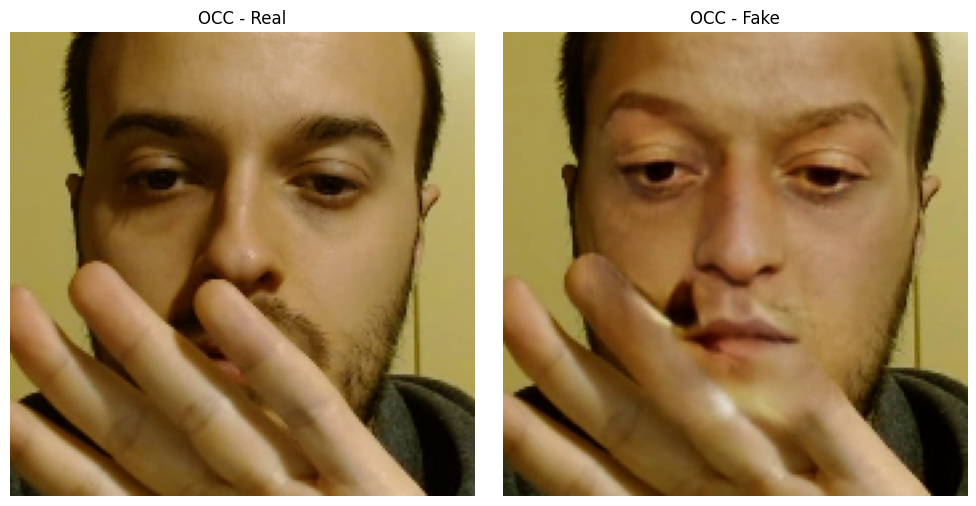

In [ ]:
#@title Select Frame Category
#@markdown Here you can select the frame category to be analyzed and visualize sample frames.

frames_type = 'occ' #@param ["occ", "no_occ"]

#@markdown [Re-run the cell to change the selection]

#  Define the paths to the preprocessed real and fake faces
real_faces_dir = preprocessed_path+f'real/{vid}/{frames_type}/'
fake_faces_dir = preprocessed_path+f'fake/{vid}/{frames_type}/'
# print(real_faces_dir)
# print(fake_faces_dir)

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns

# load the first real and fake img
real_image_path = glob.glob(real_faces_dir+'/*.jpg')[0]
fake_image_path = glob.glob(fake_faces_dir+'/*.jpg')[0]

real_image_bgr = cv2.imread(real_image_path)
fake_image_bgr = cv2.imread(fake_image_path)

# Convert BGR to RGB for matplotlib display
real_image_rgb = cv2.cvtColor(real_image_bgr, cv2.COLOR_BGR2RGB)
fake_image_rgb = cv2.cvtColor(fake_image_bgr, cv2.COLOR_BGR2RGB)

# Resize the image to be 1/3 the size
real_image_rgb = cv2.resize(real_image_rgb, (real_image_rgb.shape[1] // 3, real_image_rgb.shape[0] // 3))
fake_image_rgb = cv2.resize(fake_image_rgb, (fake_image_rgb.shape[1] // 3, fake_image_rgb.shape[0] // 3))

# Plot the occ image
axes[0].imshow(real_image_rgb)
axes[0].set_title(f'{frames_type.upper()} - Real')
axes[0].axis('off') # Hide axes ticks

# Plot the no_occ image
axes[1].imshow(fake_image_rgb) # Corrected variable name here
axes[1].set_title(f'{frames_type.upper()} - Fake')
axes[1].axis('off') # Hide axes ticks

# Adjust layout to prevent titles from overlapping
plt.tight_layout()

# Show the plot
plt.show()

# Analyze Video Data

In [ ]:
#@title Select Baseline Model
#@markdown Here you can select the baseline model to be used for testing the selected frames.

#@markdown As described in the paper, you can choose the backbone architecture (MNetv2, Xception, EffNetB4) and the training data (FOWS or GOTCHA dataset on the occ or no_occ category).
#@markdown Moreover, we provide models trained with two different training strategies, either Fine Tuning (used in the paper) and Transfer Learning.


# -------------------------------------------------------------------- #

backbone_architecture = 'mnetv2' #@param ["mnetv2", "effnetb4", "xception"]
training_data = 'gotcha_occ' #@param ["fows_occ", "fows_no_occ", "gotcha_occ", "gotcha_no_occ"]
training_strategy = 'FT' #@param ["FT", "TL"]

model_str = f'{backbone_architecture}_{training_data}_{training_strategy}'

# print(model_str)

In [ ]:
model_weights_path = './model_weights/' # path where the models will be donwloaded and loaded
# model_weights_path = '/content/drive/MyDrive/Colab Notebooks/FOWS_demo/model_weight/' # gdrive folder with all models
if not os.path.exists(model_weights_path):
    print(f"Model path {model_weights_path} does not exist")
    sys.exit()

In [ ]:
# load the model
model = get_model_from_link(model_str, model_weights_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

mnetv2_gotcha_occ_FT model weights downloaded to ./model_weights/FT/mnetv2/mnetv2_gotcha_occ_FT.pth.
Loading MobileNetV2 model
mnetv2_gotcha_occ_FT model loaded successfully.


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
#@title Compute and Plot Model Predictions

# get the test transf to prepare the data given in input to the model
test_trasnf = get_test_transf()
# get the path to the real and fake imag
real_images = glob.glob(real_faces_dir+'/*.jpg')
fake_images = glob.glob(fake_faces_dir+'/*.jpg')

# Apply test_transform to all images
original_imgs = [test_trasnf(Image.open(img).convert('RGB')) for img in real_images]
original_imgs_tensor = torch.stack(original_imgs, dim=0)  # Shape: (100, 3, 224, 224)
fake_imgs = [test_trasnf(Image.open(img).convert('RGB')) for img in fake_images]
fake_imgs_tensor = torch.stack(fake_imgs, dim=0)  # Shape: (100, 3, 224, 224)

original_all_probs = np.array(model_forward_pass(original_imgs_tensor, model, device))
# original_all_probs.shape # (100,)
# original_all_probs
fake_all_probs = np.array(model_forward_pass(fake_imgs_tensor, model, device))
# fake_all_probs.shape # (100,)
# original_all_probs

# # Plot the model predictions
# plot_prob_graph(original_all_probs, fake_all_probs, model_str, frames_type, vid)

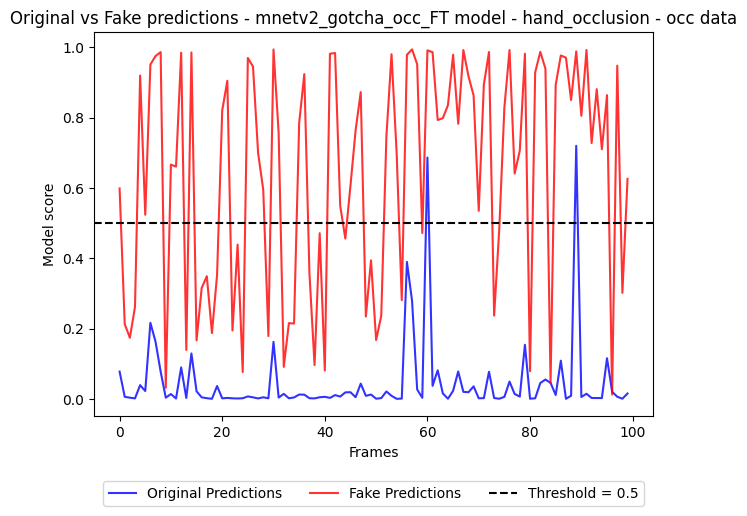

In [ ]:
# Plot the model predictions
plot_prob_graph(original_all_probs, fake_all_probs, model_str, frames_type, vid)